In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from scipy.stats.qmc import LatinHypercube
from scipy.stats import uniform, loguniform, norm
from sklearn.gaussian_process.kernels import Matern, RBF, WhiteKernel, ConstantKernel as C
from scipy.optimize import minimize
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import GPy
from datetime import datetime

# Guide and Ideas for Capstone Project - Function 1

# Searching for Contamination Sources
This may sound simple because you only have a two-dimensional input, however it is a very difficult problem. It corresponds to trying to find the source of radiation in some square area. However, you can only detect the radiation once you are very close to it, meaning most of the readings will be zero. There are two sources, one is not too dangerous, so make sure you try to find both modes of the function.

We begin this guide by downloading the data:

In [36]:
X = np.load('initial_data/function_1/initial_inputs.npy')
Y = np.load('initial_data/function_1/initial_outputs.npy')

In [37]:
def format_query(point, NoOfDigits):
    return '-'.join(f"{x:.{NoOfDigits}f}" for x in point)

In [48]:
def print_timestamp():
    # Print out the timestamp
    print("Current Timestamp: ", datetime.now())

In [38]:
# Print X with 16 digits of precision
for row in X:
    print(format_query(row,16))

# Print a separator line
print("-" * 50)

# Print Y with 16 digits of precision
print(format_query(Y,16))

0.3194038888388973-0.7629593742689353
0.5743292145098291-0.8798981049843591
0.7310236309563586-0.7329998764152272
0.8403534169072556-0.2647316139967670
0.6501140597987644-0.6815263520602101
0.4104371366251857-0.1475542990299819
0.3126911567947775-0.0787227779497188
0.6834181688515067-0.8610574643936101
0.0825072518208059-0.4034875064263240
0.8838898288181171-0.5822539743824439
--------------------------------------------------
0.0000000000000000-0.0000000000000000-0.0000000000000008-0.0000000000000000--0.0036060626443635--0.0000000000000000--0.0000000000000000-0.0000000000000000-0.0000000000000000-0.0000000000000000


In [39]:
# load w1 data
pd_new = pd.read_csv("data/capstone_results.csv")
print(pd_new.head())

   Week  Student  Fn        X1        X2        X3        X4  X5  X6  X7  X8  \
0     1      427   1  0.605439  0.664755       NaN       NaN NaN NaN NaN NaN   
1     1      427   2  0.929767  0.997474       NaN       NaN NaN NaN NaN NaN   
2     1      427   3  0.990000  0.990000  0.000000       NaN NaN NaN NaN NaN   
3     1      427   4  0.459180  0.459289  0.399209  0.408363 NaN NaN NaN NaN   
4     1      427   5  0.261839  0.845899  0.945459  0.906905 NaN NaN NaN NaN   

             Y  
0     0.007671  
1    -0.011315  
2    -0.146375  
3    -1.081020  
4  1630.468499  


In [40]:
pw_fn = pd_new[pd_new['Fn']==1]
# Extract X1 and X2 into a 2D array and Y into a 1D array
# Here we're ensuring to drop any NaN values as they can't be used in most models.
X_new_points = pw_fn[['X1','X2']].dropna().values
Y_new_points = pw_fn['Y'].dropna().values
print(X_new_points)
print(Y_new_points)

[[0.605439 0.664755]
 [0.62854  0.62854 ]
 [0.136027 0.831831]
 [0.65     0.65    ]
 [0.6      0.69    ]
 [0.65     0.65    ]
 [0.045    0.69    ]
 [0.62854  0.62854 ]
 [0.5      0.5     ]
 [0.625    0.625   ]
 [0.628078 0.627277]
 [0.628535 0.628545]
 [0.628    0.628   ]
 [0.55     0.217619]
 [0.62854  0.62854 ]
 [0.312449 0.360058]
 [0.628539 0.628539]
 [0.6291   0.6282  ]
 [0.489125 0.505089]]
[ 7.67092019e-003  2.00000000e+000 -7.26614005e-175  1.95740562e-001
 -4.16038503e-004  1.95740562e-001  5.16207364e-150  2.00000000e+000
  2.67528799e-009  1.88312832e+000  1.99133940e+000  1.99999976e+000
  1.99720443e+000 -5.44020839e-042  2.00000000e+000  3.53983517e-012
  1.99999999e+000  1.99794047e+000  8.07648397e-009]


In [41]:
def get_weekly_data(fn_no, week_no, pd_new):
    # Define the number of dimensions for each function
    fn_dim = {1: 2, 2: 2, 3: 3, 4: 4, 5: 4, 6: 5, 7: 6, 8: 8}
    
    # Get the number of dimensions for the given function number
    num_dim = fn_dim.get(fn_no, 2)  # Default to 2 if not specified

    # Filter the DataFrame for the specific week and function
    pd_fn = pd_new[(pd_new['Fn'] == fn_no) & (pd_new['Week'] == week_no)]
    
    # Dynamically create a list of 'X' column names based on the number of dimensions
    x_columns = [f'X{i}' for i in range(1, num_dim + 1)]

    # Extract X and Y values, dropping any rows with missing data
    X_new_week = pd_fn[x_columns].dropna().values
    Y_new_week = pd_fn['Y'].dropna().values
    
    return X_new_week, Y_new_week


print(get_weekly_data(1,1,pd_new))
print("\n")
print(get_weekly_data(1,2,pd_new))

(array([[0.605439, 0.664755],
       [0.62854 , 0.62854 ],
       [0.136027, 0.831831],
       [0.65    , 0.65    ],
       [0.6     , 0.69    ],
       [0.65    , 0.65    ],
       [0.045   , 0.69    ]]), array([ 7.67092019e-003,  2.00000000e+000, -7.26614005e-175,
        1.95740562e-001, -4.16038503e-004,  1.95740562e-001,
        5.16207364e-150]))


(array([[0.62854 , 0.62854 ],
       [0.5     , 0.5     ],
       [0.625   , 0.625   ],
       [0.628078, 0.627277],
       [0.628535, 0.628545],
       [0.628   , 0.628   ],
       [0.55    , 0.217619]]), array([ 2.00000000e+00,  2.67528799e-09,  1.88312832e+00,  1.99133940e+00,
        1.99999976e+00,  1.99720443e+00, -5.44020839e-42]))


In [42]:
#append w1 data to the end

X_updated = np.vstack((X, X_new_points))
Y_updated = np.append(Y, Y_new_points)
print(X_updated)
print(Y_updated)

[[0.31940389 0.76295937]
 [0.57432921 0.8798981 ]
 [0.73102363 0.73299988]
 [0.84035342 0.26473161]
 [0.65011406 0.68152635]
 [0.41043714 0.1475543 ]
 [0.31269116 0.07872278]
 [0.68341817 0.86105746]
 [0.08250725 0.40348751]
 [0.88388983 0.58225397]
 [0.605439   0.664755  ]
 [0.62854    0.62854   ]
 [0.136027   0.831831  ]
 [0.65       0.65      ]
 [0.6        0.69      ]
 [0.65       0.65      ]
 [0.045      0.69      ]
 [0.62854    0.62854   ]
 [0.5        0.5       ]
 [0.625      0.625     ]
 [0.628078   0.627277  ]
 [0.628535   0.628545  ]
 [0.628      0.628     ]
 [0.55       0.217619  ]
 [0.62854    0.62854   ]
 [0.312449   0.360058  ]
 [0.628539   0.628539  ]
 [0.6291     0.6282    ]
 [0.489125   0.505089  ]]
[ 1.32267704e-079  1.03307824e-046  7.71087511e-016  3.34177101e-124
 -3.60606264e-003 -2.15924904e-054 -2.08909327e-091  2.53500115e-040
  3.60677119e-081  6.22985647e-048  7.67092019e-003  2.00000000e+000
 -7.26614005e-175  1.95740562e-001 -4.16038503e-004  1.95740562e-00

In [43]:
def get_weekly_data(fn_no, week_no, pd_new):
    # Define the number of dimensions for each function
    fn_dim = {1: 2, 2: 2, 3: 3, 4: 4, 5: 4, 6: 5, 7: 6, 8: 8}
    
    # Get the number of dimensions for the given function number
    num_dim = fn_dim.get(fn_no, 2)  # Default to 2 if not specified

    # Filter the DataFrame for the specific week and function
    pd_fn = pd_new[(pd_new['Fn'] == fn_no) & (pd_new['Week'] == week_no)]
    
    # Dynamically create a list of 'X' column names based on the number of dimensions
    x_columns = [f'X{i}' for i in range(1, num_dim + 1)]

    # Extract X and Y values, dropping any rows with missing data
    X_new_week = pd_fn[x_columns].dropna().values
    Y_new_week = pd_fn['Y'].dropna().values
    
    return X_new_week, Y_new_week


print(get_weekly_data(1,1,pd_new))
print("\n")
print(get_weekly_data(1,2,pd_new))

(array([[0.605439, 0.664755],
       [0.62854 , 0.62854 ],
       [0.136027, 0.831831],
       [0.65    , 0.65    ],
       [0.6     , 0.69    ],
       [0.65    , 0.65    ],
       [0.045   , 0.69    ]]), array([ 7.67092019e-003,  2.00000000e+000, -7.26614005e-175,
        1.95740562e-001, -4.16038503e-004,  1.95740562e-001,
        5.16207364e-150]))


(array([[0.62854 , 0.62854 ],
       [0.5     , 0.5     ],
       [0.625   , 0.625   ],
       [0.628078, 0.627277],
       [0.628535, 0.628545],
       [0.628   , 0.628   ],
       [0.55    , 0.217619]]), array([ 2.00000000e+00,  2.67528799e-09,  1.88312832e+00,  1.99133940e+00,
        1.99999976e+00,  1.99720443e+00, -5.44020839e-42]))


## Random Search

The simplest solution would be a simple random search, that is, we can randomly choose our next query point:

In [44]:
next_query = np.random.uniform(size = 2)
print(format_query(next_query,6))

0.582880-0.998044


While this solution is easy to implement, we know it will be very slow. However, it could serve as a placeholder for gathering more information while you research which method you want to use for each function.

In [45]:
# Define the dimension and the number of samples
dim = 2  # Two-dimensional input space
n_samples = 1  # Number of initial samples

# Initialize Latin Hypercube Sampler
lhs = LatinHypercube(d=dim, seed=0)

# Generate sample points
initial_samples = lhs.random(n=n_samples)

# Scale samples to your required bounds, e.g., [0, 1] for each dimension
initial_samples = initial_samples  # Assuming bounds are [0, 1]

# Assuming bounds are [0, 1] for both dimensions
# No additional scaling needed if your bounds are already [0, 1]

# Format the output for each point
formatted_output = [format_query(point,6) for point in initial_samples]

# Print each formatted point
for point in formatted_output:
    print(point)

0.363038-0.730213


## Visualizing our data and thinking of the problem

It is important when tackling problems to really think about the best strategy and to do some exploratory data analysis. Let's consider what we know about the problem:

1. From the hints, we expect two modes in the unknown function.

2. From the hints, we know that most of our queries should be zero!

3. The problem is two-dimensional.

4. The problem will have small length-scale (that is, we expect the modes to be very small)

From (3.) we can take advantage, and plot the initial data:

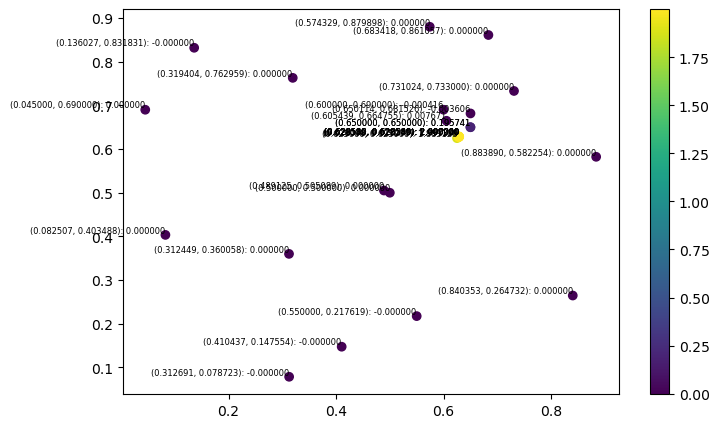

In [12]:
fig, ax = plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(8)

# Scatter plot
scatter = ax.scatter(X_updated[:, 0], X_updated[:, 1], c=Y_updated)

# Adding a color bar
plt.colorbar(scatter)

# Looping over the data points to add labels with 16 digits of precision
for i in range(len(X_updated)):
    x_coord = f"{X_updated[i, 0]:.6f}"
    y_coord = f"{X_updated[i, 1]:.6f}"
    y_value = f"{Y_updated[i]:.6f}"
    label = f"({x_coord}, {y_coord}): {y_value}"
    ax.text(X_updated[i, 0], X_updated[i, 1], label, fontsize=6, ha='right', va='bottom')

plt.show()


## create voroni diagram

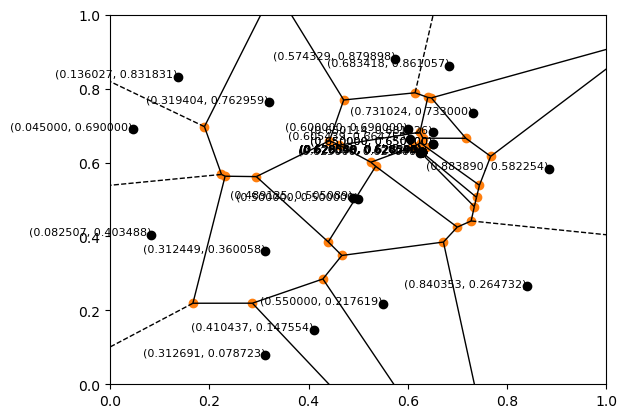

In [13]:
# create voroni diagram

from scipy.spatial import Voronoi, voronoi_plot_2d

# dataset points
points = X_updated

# Creating the Voronoi diagram
vor = Voronoi(points)

# Plotting the Voronoi diagram
fig, ax = plt.subplots()
voronoi_plot_2d(vor, ax=ax, show_vertices=True)
ax.plot(points[:, 0], points[:, 1], 'ko')

# Annotating each point with its coordinates
for point in points:
    label = f'({point[0]:.6f}, {point[1]:.6f})'  # Format the label to two decimal places
    ax.text(point[0], point[1], label, fontsize=8, ha='right')


# Optionally, set the limits of the plot to ensure all annotations are visible
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])

plt.show()


## Maximum Empty Circle or MEC in a Voronoi diagram (Convex)

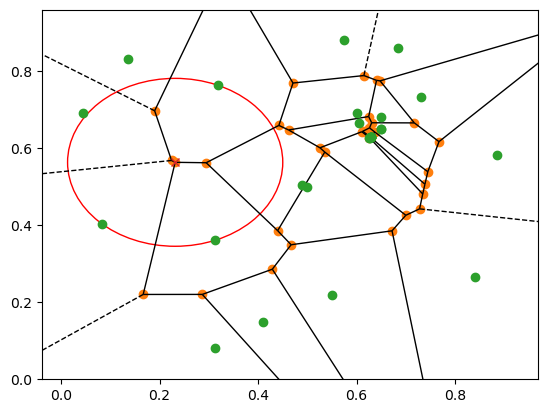

Center of the largest empty circle: 0.231700-0.562963
Radius of the largest empty circle: 0.21838204495438046


In [14]:
from scipy.spatial import ConvexHull

# Compute Convex Hull
hull = ConvexHull(points)

# Function to check if a point is inside the convex hull
def in_hull(p, hull):
    if not isinstance(hull, ConvexHull):
        hull = ConvexHull(hull)
    return all((np.dot(eq[:-1], p) + eq[-1] <= 0) for eq in hull.equations)

# Find the largest empty circle
max_radius = 0
center_of_max_circle = None

for vertex in vor.vertices:
    if in_hull(vertex, hull):
        min_distance_to_point = min(np.linalg.norm(vertex - point) for point in points)
        if min_distance_to_point > max_radius:
            max_radius = min_distance_to_point
            center_of_max_circle = vertex

# Plotting for visualization
voronoi_plot_2d(vor)
plt.plot(points[:,0], points[:,1], 'o')
if center_of_max_circle is not None:
    plt.plot(center_of_max_circle[0], center_of_max_circle[1], 'x')
    circle = plt.Circle(center_of_max_circle, max_radius, color='r', fill=False)
    plt.gca().add_artist(circle)
plt.show()

if center_of_max_circle is not None:
    print("Center of the largest empty circle:", format_query(center_of_max_circle,6))
    print("Radius of the largest empty circle:", max_radius)
else:
    print("No empty circle found within the convex hull.")

## Maximum Empty Circle or MEC in a Voronoi diagram

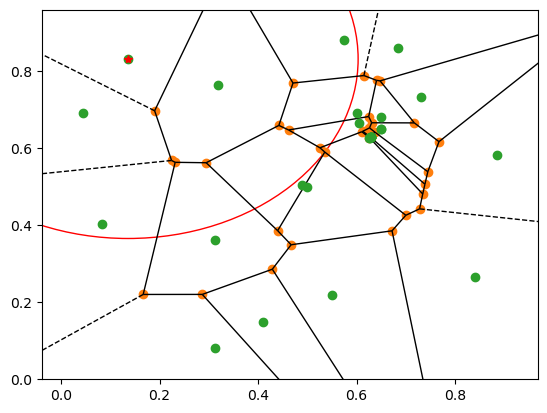

Center of the largest empty circle: 0.136027-0.831831
Radius of the largest empty circle: 0.46699856217364505


In [15]:
from scipy.spatial import Voronoi, voronoi_plot_2d

def largest_empty_circle(points):
    # Compute Voronoi diagram
    vor = Voronoi(points)
    
    # Iterate over Voronoi regions
    max_radius = 0
    best_point = None
    for point, region in zip(vor.points, vor.regions):
        if not region or -1 in region:
            continue

        # Compute the distances from the point to all edges of its Voronoi region
        region_points = np.asarray([vor.vertices[i] for i in region])
        distances = np.sqrt(((region_points - point) ** 2).sum(axis=1))

        # Find the maximum distance
        min_distance = np.min(distances)
        if min_distance > max_radius:
            max_radius = min_distance
            best_point = point

    return best_point, max_radius

# dataset points
points = X_updated
center, radius = largest_empty_circle(points)

# Plotting
voronoi_plot_2d(Voronoi(points))
plt.plot(points[:, 0], points[:, 1], 'o')
plt.plot(center[0], center[1], '*r')
circle = plt.Circle(center, radius, color='r', fill=False)
plt.gca().add_patch(circle)
plt.show()

if center is not None:
    print("Center of the largest empty circle:", format_query(center,6))
    print("Radius of the largest empty circle:", radius)
else:
    print("No empty circle found.")


## The best point is [0.62854,	0.62854]


In [16]:
#Using a Kernel Density Estimate (KDE)
from scipy.stats import gaussian_kde

# existing 2D dataset
points = X_updated 

# Fit KDE to data
data_kde = gaussian_kde(points.T)

# Best point coordinates (can be expanded to more dimensions)
best_points = [0.628535, 0.628545] 

# Define the threshold for each dimension (assuming the same threshold for all dimensions)
threshold = 0.1  #  threshold value

# Calculate min and max values for each dimension based on the new threshold
min_values = [max(0, x - threshold) for x in best_points]
max_values = [min(1, x + threshold) for x in best_points]

# Increase the number of samples significantly
num_samples = 10000  # Try with a larger number of samples

# Sample new points from the KDE
kde_samples = data_kde.resample(size=num_samples)

# Filter the samples to only keep those within the defined region
conditions = [(kde_samples[i] >= min_values[i]) & (kde_samples[i] <= max_values[i]) for i in range(len(best_points))]
conditions += [(kde_samples[i] >= 0) & (kde_samples[i] <= 1) for i in range(len(best_points))]  # Ensure all dimensions are within [0, 1]
kde_samples_filtered = kde_samples[:, np.all(conditions, axis=0)].T

# Check if we have any points after filtering
if kde_samples_filtered.size == 0:
    raise ValueError("No points sampled within the specified region. Try increasing the number of samples or adjusting the region bounds.")

# Now kde_samples_filtered should contain new points sampled from the KDE within the specified region
#print(kde_samples_filtered.T)  # Transposed for easier readability


target_point = np.array([0.5, 0.5])

# Compute the Euclidean distances from each point in the dataset to the target point
distances = np.linalg.norm(kde_samples_filtered - target_point, axis=1)

# Get the indices of the 10 closest points
closest_indices = np.argsort(distances)[:10]

# Retrieve the closest points using these indices
closest_points = kde_samples_filtered[closest_indices]

print("The 10 closest points to (0.5, 0.5) are:")
print(closest_points)

The 10 closest points to (0.5, 0.5) are:
[[0.53473955 0.53138179]
 [0.53827515 0.52902335]
 [0.53972151 0.53176072]
 [0.53810382 0.53482529]
 [0.537178   0.53665091]
 [0.54427755 0.5301441 ]
 [0.53269203 0.54403004]
 [0.54171654 0.53785381]
 [0.54623488 0.53477907]
 [0.54644553 0.53604015]]


In [17]:
# Convert to DataFrame for easier handling
df = pd.DataFrame(X_updated, columns=['x1', 'x2'])
df['output'] = Y_updated

In [18]:
# Statistical Summary
print("Statistical Summary:")
print(df.describe())

Statistical Summary:
              x1         x2         output
count  29.000000  29.000000   2.900000e+01
mean    0.540658   0.579508   6.298187e-01
std     0.204544   0.200173   9.270811e-01
min     0.045000   0.078723  -3.606063e-03
25%     0.489125   0.505089  3.341771e-124
50%     0.628000   0.628540   3.539835e-12
75%     0.629100   0.681526   1.991339e+00
max     0.883890   0.879898   2.000000e+00


We know that function has two kinds of local maximums, thanks to the hints, we also expect most of our reading to be zero. The fact that we have a perturbation or non-zero value at  𝑥
  = [0.650114059798764, 0.68152635206021] means we should be interested in this area. An alternative solution would be to focus only on this area, there are two ways to do this:

Run random search in an area restricted around  𝑥
  = [0.650114059798764, 0.68152635206021]

Solve the UCB in an area restricted around  𝑥
  = [0.650114059798764, 0.68152635206021]

Below we provide code for both:

In [19]:
#Appoach 1

# Random search around an area restricted around
# best points so far
# 0.628540	0.628540	2.000000
# 0.650000	0.650000	0.195741

delta = 0.05

# Given the best points are around 0.65, we want to center our search around this value
# and expand slightly beyond it to continue exploring.
domain_start_x1 = 0.6 - delta  # Now starts slightly below the best points
domain_end_x1 = 0.7 + delta    # Now ends slightly above the best points
domain_start_x2 = 0.6 - delta  
domain_end_x2 = 0.7 + delta     
print(f"domain_start_x1= {domain_start_x1} and domain_end_x1 = {domain_end_x1}")

next_query_x1 = np.random.normal(domain_start_x1, scale = 0.01)
next_query_x2 = np.random.normal(domain_end_x1, scale = 0.01)
print('Next query Random: ', [next_query_x1, next_query_x2])

domain_start_x1= 0.5499999999999999 and domain_end_x1 = 0.75
Next query Random:  [0.5485067439539776, 0.7503771506638189]


In [20]:
def compute_kappa_xi_arrays(N_WEEKS, kappa_initial, kappa_decay, min_kappa, xi_initial, xi_decay, min_xi):
    """
    Compute kappa and xi values for each week in an optimization loop.

    Parameters:
    N_WEEKS: Number of weeks for the optimization loop.
    kappa_initial: Initial value of kappa.
    kappa_decay: Decay rate of kappa per week.
    min_kappa: Minimum value of kappa.
    xi_initial: Initial value of xi.
    xi_decay: Decay rate of xi per week.
    min_xi: Minimum value of xi.

    Returns:
    kappa_array: Array of kappa values for each week.
    xi_array: Array of xi values for each week.
    """

    kappa_array = np.zeros(N_WEEKS)
    xi_array = np.zeros(N_WEEKS)

    for week in range(N_WEEKS):
        kappa = max(kappa_initial * (kappa_decay ** week), min_kappa)
        xi = max(xi_initial * (xi_decay ** week), min_xi)
        kappa_array[week] = kappa
        xi_array[week] = xi

    return kappa_array, xi_array

# Example usage:
N_WEEKS = 10
kappa_initial = 1.96
kappa_decay = 0.9
min_kappa = 0.1
xi_initial = 0.1
xi_decay = 0.9
min_xi = 0.01

kappa_array, xi_array = compute_kappa_xi_arrays(N_WEEKS, kappa_initial, kappa_decay, min_kappa, xi_initial, xi_decay, min_xi)
print("Kappa Array:", kappa_array)
print("Xi Array:", xi_array)

Kappa Array: [1.96       1.764      1.5876     1.42884    1.285956   1.1573604
 1.04162436 0.93746192 0.84371573 0.75934416]
Xi Array: [0.1        0.09       0.081      0.0729     0.06561    0.059049
 0.0531441  0.04782969 0.04304672 0.03874205]


In [21]:
#Evaluate Model Performance

def evaluate_model_performance(model, X_test, Y_test, model_type='sklearn'):
    """
    Evaluate the performance of a Gaussian Process model.

    Parameters:
    model: The trained Gaussian Process model.
    X_test: Test data features (numpy array).
    Y_test: True values for test data (numpy array).

    Returns:
    mse: Mean Squared Error of the model on the test data.
    r2: R-squared value indicating the proportion of variance explained by the model.
    """

    if model_type == 'gpy':
        y_pred, var_pred = model.predict(X_test)
        std_pred = np.sqrt(var_pred)
    elif model_type == 'sklearn':
        y_pred, std_pred = model.predict(X_test, return_std=True)

    # Ensure y_pred is 1D
    y_pred = y_pred.flatten()

    # Calculate residuals
    residuals = Y_test.flatten() - y_pred

    # Check if dimensions match
    if y_pred.shape != residuals.shape:
        raise ValueError(f"Shape mismatch: y_pred shape {y_pred.shape} and residuals shape {residuals.shape} must be the same.")        
        
    # Calculate MSE and R-squared
    mse = mean_squared_error(Y_test, y_pred)
    r2 = r2_score(Y_test, y_pred)
    
    print(f"MSE: {mse}")
    print(f"R-squared: {r2}")

    # Analyze residuals
    residuals = Y_test - y_pred

    # Plot residuals to look for patterns
    plt.scatter(y_pred, residuals)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title('Residual Plot')
    plt.show()

    return mse, r2

# Usage example:
# mse, r2 = evaluate_model_performance(best_gp, X_w1_new_points, Y_w1_new_points)
# print(f"MSE: {mse}")
# print(f"R-squared: {r2}")


In [22]:


#an acquisition function used in Bayesian optimization. 
# The EI is calculated for a set of points X, given a Gaussian process gp. It's used to determine the next point to sample.
def expected_improvement(X_grid, gp, xi=0.01, model_type='gpy'):
    if model_type == 'gpy':
        mu, var = gp.predict(X_grid)
        sigma = np.sqrt(var)
        mu_sample_opt = np.max(gp.predict(gp.X))
    elif model_type == 'sklearn':
        mu, sigma = gp.predict(X, return_std=True)
        mu_sample_opt = np.max(gp.predict(gp.X_train_, return_std=False))

    with np.errstate(divide='warn'):
        imp = mu - mu_sample_opt - xi
        Z = imp / sigma
        ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
        ei[sigma == 0.0] = 0.0

    return ei


# Probability of Improvement acquisition function
def probability_of_improvement(X_grid, gp, xi=0.01, model_type='gpy'):
    if model_type == 'gpy':
        mu, var = gp.predict(X_grid)
        sigma = np.sqrt(var)
        mu_sample_opt = np.max(gp.predict(gp.X))
    elif model_type == 'sklearn':
        mu, sigma = gp.predict(X_grid, return_std=True)
        mu_sample_opt = np.max(gp.predict(gp.X_train_, return_std=False))

    with np.errstate(divide='warn'):
        imp = mu - mu_sample_opt - xi
        Z = imp / sigma
        pi = norm.cdf(Z)
        pi[sigma == 0.0] = 0.0

    return pi


# Define the UCB acquisition function
# After optimizing the hyperparameters, the Upper Confidence Bound (UCB) is used as the acquisition function in the weekly optimization loop. 
# The UCB balances exploration (trying new, uncertain points) and exploitation (focusing on points known to yield good results).
def upper_confidence_bound(X_grid, gp, kappa=1.96, model_type='gpy'):
    if model_type == 'gpy':
        mu, var = gp.predict(X_grid)
        sigma = np.sqrt(var)
    elif model_type == 'sklearn':
        mu, sigma = gp.predict(X_grid, return_std=True)

    return mu + kappa * sigma



In [23]:
def generate_2d_grid(domain_start_x1, domain_end_x1, domain_start_x2, domain_end_x2, num_points):
    """
    Generate a 2D grid of points for optimization.

    Parameters:
    domain_start_x1: Starting value of the first dimension.
    domain_end_x1: Ending value of the first dimension.
    domain_start_x2: Starting value of the second dimension.
    domain_end_x2: Ending value of the second dimension.
    num_points: Number of points to generate in each dimension.

    Returns:
    X_grid: A 2D numpy array of grid points.
    """

    # Generate arrays of evenly spaced values in each dimension
    x1 = np.linspace(domain_start_x1, domain_end_x1, num_points)
    x2 = np.linspace(domain_start_x2, domain_end_x2, num_points)

    # Use numpy's meshgrid function to create a grid efficiently
    X_grid = np.array(np.meshgrid(x1, x2)).T.reshape(-1, 2)

    return X_grid
# Example usage:
# domain_start_x1, domain_end_x1, domain_start_x2, domain_end_x2 = 0.6, 0.65, 0.6, 0.65
# num_points = 100
# X_grid = generate_2d_grid(domain_start_x1, domain_end_x1, domain_start_x2, domain_end_x2, num_points)

def generate_nd_grid(max_points, dimensions):
    # define range for input
	r_min, r_max = 0, 1.0

	# generate a random sample from the domain (dimensions)
	nd_grid = r_min + np.random.rand(max_points, dimensions) * (r_max - r_min)
	
	return np.array(nd_grid)


In [24]:
def propose_next_point(xi, kappa, X_grid, best_gp, model_type = 'sklearn'):
    """
    Update exploration-exploitation parameters and calculating next query points.
   
    Returns:
    Next query points for EI, PI, and UCB.
    """


    # EI next point calculation
    ei_values = expected_improvement(X_grid, best_gp, xi,model_type)
    next_point_index_ei = np.argmax(ei_values)
    next_point_ei = X_grid[next_point_index_ei]
    print('Next query EI: ', format_query(next_point_ei, 6))

    # PI next point calculation
    pi_values = probability_of_improvement(X_grid, best_gp, xi,model_type)
    next_point_index_pi = np.argmax(pi_values)
    next_point_pi = X_grid[next_point_index_pi]
    print('Next query PI: ', format_query(next_point_pi, 6))

    # UCB next point calculation
    ucb_value = upper_confidence_bound(X_grid, best_gp, kappa,model_type)
    next_point_index_ucb = np.argmax(ucb_value)
    next_point_ucb = X_grid[next_point_index_ucb]
    print('Next query UCB: ', format_query(next_point_ucb, 6))

    return next_point_ei, next_point_pi, next_point_ucb



# Approach 2 sklearn: train accumulatively

In [26]:
#Approach 2 - modified
#Randomized Hyperparameter Search: 
#defines a search space for the kernel parameters, creates a Gaussian process model, and then uses RandomizedSearchCV to find the best hyperparameters based on cross-validation. 
# The best model and parameters are then displayed.
param_distributions = {
    'kernel__k1__constant_value': loguniform(1e-3, 1e3),
    'kernel__k2__length_scale': loguniform(1e-4, 1e2)  
}

kernel = C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-2, 1e2))  

gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=20)

random_search = RandomizedSearchCV(gp, param_distributions, n_iter=10, cv=5, random_state=42, n_jobs=-1)
random_search.fit(X_updated,Y_updated)

best_gp = random_search.best_estimator_
best_params = random_search.best_params_
print("Best Parameters:", best_params)
print(f"Log-marginal-likelihood: {best_gp.log_marginal_likelihood(best_gp.kernel_.theta)}")

 C:\Users\jdche\AppData\Roaming\Python\Python310\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning:lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


Best Parameters: {'kernel__k1__constant_value': 24.658329458549098, 'kernel__k2__length_scale': 0.390796715682288}
Log-marginal-likelihood: 54.349059850380115


## Approach 2 sklearn - alternative: train sequentially

In [34]:
#Approach 2 - alternative
#Randomized Hyperparameter Search: 
#defines a search space for the kernel parameters, creates a Gaussian process model, and then uses RandomizedSearchCV to find the best hyperparameters based on cross-validation. 
# The best model and parameters are then displayed.
# Define your initial kernel and model
kernel = C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=20)

# Define hyperparameter search space
param_distributions = {
    'kernel__k1__constant_value': loguniform(1e-4, 1e3),
    'kernel__k2__length_scale': loguniform(1e-4, 1e2)
}

# Function to update model with new data and optimize hyperparameters
def update_and_optimize_model(gp, X_train, Y_train):
    # Update the model with new data
    gp.fit(X_train, Y_train)

    # Hyperparameter optimization
    random_search = RandomizedSearchCV(gp, param_distributions, n_iter=10, cv=5, random_state=42, n_jobs=-1)
    random_search.fit(X_train, Y_train)

    # Best model and parameters
    best_gp = random_search.best_estimator_
    best_params = random_search.best_params_
    print("Best Parameters:", best_params)
    print(f"Log-marginal-likelihood: {best_gp.log_marginal_likelihood(best_gp.kernel_.theta)}") # Higher values typically indicate a better fit. can sometimes indicate overfitting
    
    return best_gp

# Initial training data
X_train = X # the initial X data
Y_train = Y # the initial Y data

# Initial model fitting and hyperparameter optimization
best_gp = update_and_optimize_model(gp, X_train, Y_train)

number_of_weeks =2 # this is the 3rd week, we have additional 2 weeks data

# Example usage for weekly updates
for week in range(number_of_weeks):
    print(f"week = {week}")
    # Assume X_new_week and Y_new_week are the new data you receive every week
    X_new_week, Y_new_week = get_weekly_data(1,week+1, pd_new)
    
    # Combine old training data with new data
    X_train = np.vstack((X_train, X_new_week))
    Y_train = np.hstack((Y_train, Y_new_week))

    # Update the model with new data and optimize hyperparameters
    best_gp = update_and_optimize_model(best_gp, X_train, Y_train)



 C:\Users\jdche\AppData\Roaming\Python\Python310\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning:The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
 C:\Users\jdche\AppData\Roaming\Python\Python310\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning:The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.


Best Parameters: {'kernel__k1__constant_value': 1.6136341713591318, 'kernel__k2__length_scale': 1.7718847354806815}
Log-marginal-likelihood: 34.05742991173904
week = 0


 C:\Users\jdche\AppData\Roaming\Python\Python310\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning:lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
 C:\Users\jdche\AppData\Roaming\Python\Python310\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning:lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


Best Parameters: {'kernel__k1__constant_value': 0.10558813779064831, 'kernel__k2__length_scale': 0.005589524205217923}
Log-marginal-likelihood: -1.3332712120303984
week = 1


 C:\Users\jdche\AppData\Roaming\Python\Python310\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning:lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
 C:\Users\jdche\AppData\Roaming\Python\Python310\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning:lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


Best Parameters: {'kernel__k1__constant_value': 0.04185822729546973, 'kernel__k2__length_scale': 50.61576888752303}
Log-marginal-likelihood: 27.170622091120837


## Appoach 2: using sklearn GP model via 2D grid

Next query EI:  0.550000-0.550000
Next query PI:  0.643093-0.613263
Next query UCB:  0.628278-0.628879
MSE: 5.481808412543051e-13
R-squared: 0.9999999999994215


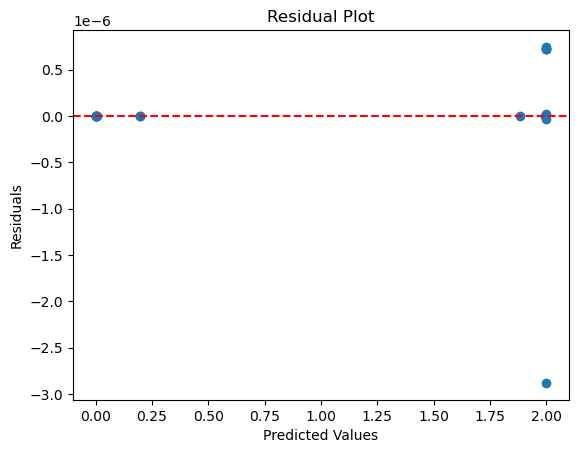

In [27]:


# best points so far: 
# 0.628540	0.628540	2.000000
# 0.650000	0.650000	0.195741
# to optimize the acquisition function, we will simply use gridsearch over a space of 10.000 gridpoints
#the NumPy library's linspace function to generate an array x1 evenly spaced numbers: start of 0.6; end of 0.65; 100 samples to generate
# Use numpy's meshgrid function to create a grid efficiently
num_points = 1000
X_grid = generate_2d_grid(domain_start_x1, domain_end_x1, domain_start_x2, domain_end_x2, num_points)

# Select updated kappa & xi based on the nth week
# Example for a specific week (e.g., week 1)
week_index = 3  # For week 4, as indexing starts from 0
xi_value = xi_array[week_index]
kappa_value = kappa_array[week_index]


# EI, PI, UCB next point calcuation
next_point_ei, next_point_pi, next_point_ucb = propose_next_point(xi_value,kappa_value,X_grid,best_gp,'sklearn')

mse, r2 = evaluate_model_performance(best_gp, X_new_points, Y_new_points,'sklearn')
#print(f"MSE: {mse}")
#print(f"R-squared: {r2}")

## Appoach 2: using sklearn GP model via Voronoi diagram generated grid

Next query EI:  0.672556-0.683698
Next query PI:  0.642285-0.614563
Next query UCB:  0.629900-0.630547
MSE: 5.481808412543051e-13
R-squared: 0.9999999999994215


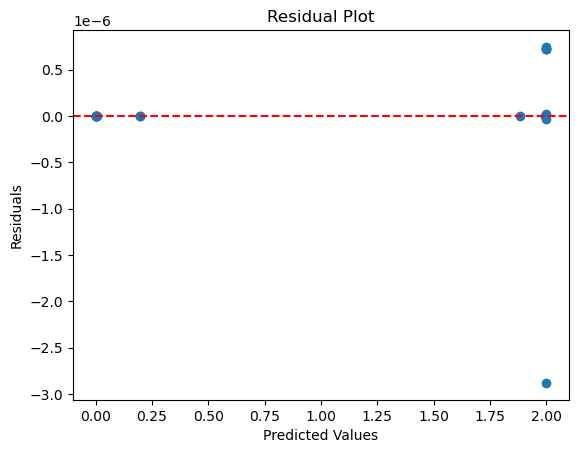

In [28]:
# Select updated kappa & xi based on the nth week
# Example for a specific week (e.g., week 1)
week_index = 3  # For week 3, as indexing starts from 0
xi_value = xi_array[week_index]
kappa_value = kappa_array[week_index]


# EI, PI, UCB next point calcuation
next_point_ei, next_point_pi, next_point_ucb = propose_next_point(xi_value,kappa_value,kde_samples_filtered,best_gp,'sklearn')

mse, r2 = evaluate_model_performance(best_gp, X_new_points, Y_new_points,'sklearn')
#print(f"MSE: {mse}")
#print(f"R-squared: {r2}")

## Aproach 3:  a Sparse Gaussian Process model

In [29]:
# aproach 3


# Assuming X_w1 and Y_w1 are your data points
# Ensure X_w1 and Y_w1 are correctly shaped
# X_w1 = ... (your data, should be 2D, e.g., [n_samples, n_features])
# Y_w1 = ... (your data, should be 2D, e.g., [n_samples, 1])

# If Y_w1 is 1D, convert it to 2D
if Y_updated.ndim == 1:
    Y_updated_2d = Y_updated[:, np.newaxis]

# Create a kernel with RBF
kernel = GPy.kern.RBF(input_dim=X_updated.shape[1], variance=1., lengthscale=1.)

# Number of inducing points - this can be tuned based on your problem
num_inducing = 10  # This is an example value

# Creating a Sparse Gaussian Process Model
gp_sparse = GPy.models.SparseGPRegression(X_updated, Y_updated_2d, kernel, num_inducing=num_inducing)

# Model Optimization
gp_sparse.optimize(messages=True, optimizer='lbfgsb', max_iters=1000)

# Optionally, you can constrain parameters to be positive
gp_sparse.constrain_positive()

# After optimization, you can check the optimized hyperparameters
print("Optimized kernel parameters:", gp_sparse.kern)
print("Optimized noise variance:", gp_sparse.Gaussian_noise.variance)

# Evaluate model performance on a validation set, X_val and Y_val
Y_pred, Y_var = gp_sparse.predict(X_new_points)
mse = np.mean((Y_new_points - Y_pred)**2)
print("MSE on validation set:", mse)

reconstraining parameters sparse_gp


Optimized kernel parameters:   rbf.         |                 value  |  constraints  |  priors
  variance     |   0.12649465609425742  |      +ve      |        
  lengthscale  |  0.015053331110676893  |      +ve      |        
Optimized noise variance:   index  |  sparse_gp.Gaussian_noise.variance  |  constraints  |  priors
  [0]    |                         0.09878058  |      +ve      |        
MSE on validation set: 1.7453548303308764


In [39]:
#print(dir(gp_sparse))


['Gaussian_noise', 'X', 'Y', 'Y_metadata', 'Y_normalized', 'Z', '_IN_OPTIMIZATION_', '_Parameterizable__visited', '_Zgrad', '__class__', '__deepcopy__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setitem__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_add_io', '_add_parameter_name', '_add_to_index_operations', '_added_names_', '_allowed_failures', '_build_from_input_dict', '_checkgrad', '_connect_fixes', '_connect_parameters', '_default_constraint_', '_default_prior_', '_description_str', '_disconnect_parent', '_ensure_fixes', '_fail_count', '_fixes_', '_format_input_dict', '_format_spec', '_get_original', '_gradient_array_', '_grads', '_has_fixes', '_highest_parent_', '_in_init_', '_index_opera

Next query EI:  0.628078-0.627878
Next query PI:  0.628078-0.627878
Next query UCB:  0.628078-0.627878
MSE: 0.012385627186877603
R-squared: 0.9869291957974935


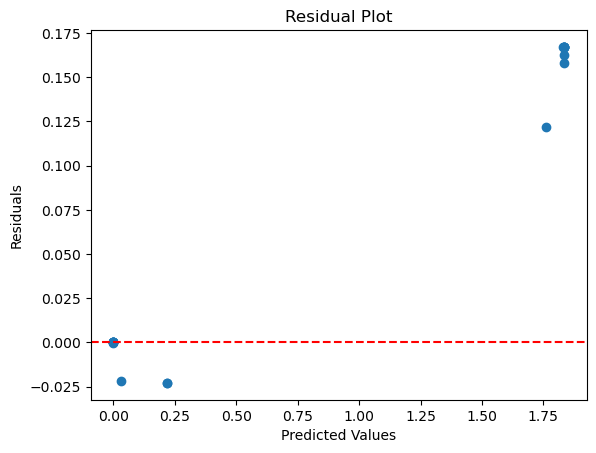

In [30]:
# EI, PI, UCB next point calcuation
next_point_ei, next_point_pi, next_point_ucb = propose_next_point(xi_value,kappa_value,X_grid, gp_sparse,'gpy')

mse, r2 = evaluate_model_performance(gp_sparse, X_new_points, Y_new_points,'gpy')
#print(f"MSE: {mse}")
#print(f"R-squared: {r2}")

## Bayesian Hyperparameter Optimization

In [49]:
from bayes_opt import BayesianOptimization
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

# initial dataset: X, Y; new dataset: X_new_points , Y_new_points

X_train,y_train = X, Y
X_val,y_val = X_new_points , Y_new_points

# Define the black-box function to optimize, using the validation set for evaluation
def svr_eval(C, gamma):
    model = SVR(C=C, gamma=gamma)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    mse = mean_squared_error(y_val, y_pred)  # Using Mean Squared Error as the metric
    return -mse  # Negate the MSE because BayesianOptimization maximizes the function

# Define the bounds of the hyperparameters
pbounds = {'C': (0.1, 100), 'gamma': (0.01, 1)}

# Instantiate Bayesian Optimization
optimizer = BayesianOptimization(f=svr_eval, pbounds=pbounds, random_state=1)

# Maximize the accuracy on the validation set
optimizer.maximize(init_points=2, n_iter=10)

# Print the best parameters and score
print("Best parameters:", optimizer.max['params'])
print("Best score:", optimizer.max['target'])

print_timestamp()


|   iter    |  target   |     C     |   gamma   |
-------------------------------------------------
| 1         | -1.876    | 41.76     | 0.7231    |
| 2         | -1.876    | 0.1114    | 0.3093    |
| 3         | -1.876    | 99.99     | 0.1285    |
| 4         | -1.876    | 83.02     | 0.6635    |
| 5         | -1.876    | 0.1011    | 0.364     |
| 6         | -1.876    | 100.0     | 0.9732    |
| 7         | -1.876    | 39.62     | 0.1698    |
| 8         | -1.876    | 88.78     | 0.4527    |
| 9         | -1.876    | 0.1118    | 0.07343   |
| 10        | -1.876    | 0.1014    | 0.5718    |
| 11        | -1.876    | 99.99     | 0.4353    |
| 12        | -1.876    | 14.93     | 0.4126    |
Best parameters: {'C': 41.76049826978715, 'gamma': 0.7231212485077365}
Best score: -1.8755169377233973
Current Timestamp:  2024-02-04 15:18:13.258186


In [51]:
print(format_query(y_val,6))

0.007671-2.000000--0.000000-0.195741--0.000416-0.195741-0.000000-2.000000-0.000000-1.883128-1.991339-2.000000-1.997204--0.000000-2.000000-0.000000-2.000000-1.997940-0.000000


In [52]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

def rf_eval(n_estimators, max_depth):
    model = RandomForestRegressor(n_estimators=int(n_estimators), 
                                  max_depth=int(max_depth), 
                                  random_state=1)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    mse = mean_squared_error(y_val, y_pred)
    return -mse  # Negate the MSE because BayesianOptimization maximizes the function

# Define the bounds of the hyperparameters
pbounds = {'n_estimators': (10, 100), 'max_depth': (1, 50)}

# Instantiate Bayesian Optimization
optimizer = BayesianOptimization(f=rf_eval, pbounds=pbounds, random_state=1)

# Maximize the negative MSE on the validation set
optimizer.maximize(init_points=2, n_iter=10)

# Print the best parameters and score
print("Best parameters:", optimizer.max['params'])
print("Best MSE (negative):", optimizer.max['target'])


|   iter    |  target   | max_depth | n_esti... |
-------------------------------------------------
| 1         | -1.875    | 21.43     | 74.83     |
| 2         | -1.873    | 1.006     | 37.21     |
| 3         | -1.875    | 2.217     | 36.89     |
| 4         | -1.875    | 41.67     | 69.41     |
| 5         | -1.875    | 8.316     | 66.59     |
| 6         | -1.875    | 5.218     | 78.28     |
| 7         | -1.875    | 20.39     | 24.53     |
| 8         | -1.875    | 44.5      | 50.25     |
| 9         | -1.873    | 1.106     | 37.34     |
| 10        | -1.873    | 1.0       | 38.02     |
| 11        | -1.873    | 1.058     | 39.53     |
| 12        | -1.873    | 1.169     | 41.04     |
Best parameters: {'max_depth': 1.0, 'n_estimators': 38.02233059368047}
Best MSE (negative): -1.8731360240125672


## For Bayesian Optimization with Custom Acquisition Function for larger dataset

In [56]:
from bayes_opt import BayesianOptimization
from sklearn.ensemble import RandomForestRegressor

# datasets
X_train,y_train = X, Y
X_val,y_val = X_new_points , Y_new_points


# Objective function to optimize
def objective_function(n_estimators, max_depth):
    # RandomForestRegressor for regression tasks
    model = RandomForestRegressor(n_estimators=int(n_estimators), max_depth=int(max_depth))
    model.fit(X_train, y_train)
    mse = mean_squared_error(y_val, model.predict(X_val))
    return -mse  # Negate MSE because Bayesian Optimization maximizes the function

# Define the bounds of the search space
bounds = {'n_estimators': (10, 100), 'max_depth': (1, 10)}

# Instantiate Bayesian Optimization
optimizer = BayesianOptimization(f=objective_function, pbounds=bounds, random_state=1)

# Perform optimization
optimizer.maximize(init_points=2, n_iter=5)

# Output the best parameters and score (note that score is negated MSE)
print("Best parameters:", optimizer.max['params'])
print("Best MSE (negative):", optimizer.max['target'])

|   iter    |  target   | max_depth | n_esti... |
-------------------------------------------------
| 1         | -1.876    | 4.753     | 74.83     |
| 2         | -1.873    | 1.001     | 37.21     |
| 3         | -1.875    | 2.245     | 37.7      |
| 4         | -1.875    | 8.47      | 69.41     |
| 5         | -1.876    | 2.344     | 66.59     |
| 6         | -1.873    | 1.364     | 36.9      |
| 7         | -1.874    | 1.256     | 35.35     |
Best parameters: {'max_depth': 1.001029373356104, 'n_estimators': 37.20993153686558}
Best MSE (negative): -1.8729045798697983
